In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [2]:
import multiprocessing

import pandas as pd
import datamol as dm
import numpy as np
import seaborn as sns

from molfeat.calc import RDKitDescriptors2D, FPCalculator, MordredDescriptors
from molfeat.trans import MoleculeTransformer
from sklearn.preprocessing import OneHotEncoder

import collections.abc as collections
from molfeat.trans.concat import FeatConcat

from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from src.config import mem
from src.utils import embed3d, embed_auto3d, eval_model, OffsetScaler, mol2smi, smi2mol
from src.descriptors import calc_dgl_feats, calc_hft_feats, calc_3d_feats, calc_2d_feats

from rdkit import RDLogger, Chem
RDLogger.DisableLog('rdApp.*')

In [3]:
train = dm.read_csv('../data/processed/train.csv', smiles_column='smi', index_col=0)
test = dm.read_csv('../data/processed/test.csv', smiles_column='smi', index_col=0)

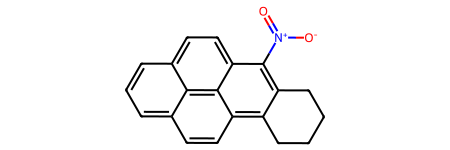

In [4]:
train.mol[0]

In [39]:
from molfeat.trans.fp import FPVecTransformer

from molfeat.trans.pretrained import PretrainedDGLTransformer
from molfeat.trans.pretrained.hf_transformers import PretrainedHFTransformer

ADD_3D_FEATS = True

feats2D_params = [
    # fps
    {'kind': 'ecfp:4', 'length': 1024},
    {'kind': 'maccs', 'n_jobs': -1},
    {'kind': 'topological', 'length': 1024, 'n_jobs': -1},
    {'kind': 'avalon', 'length': 1024, 'n_jobs': -1},
    {'kind': 'erg', 'n_jobs': -1},
    {'kind': 'layered', 'length': 1024, 'n_jobs': -1},
    {'kind': 'secfp', 'length': 1024, 'n_jobs': -1},
    {'kind': 'pattern', 'length': 1024},
    {'kind': 'pharm2D', 'length': 1024, 'n_jobs': -1},
    
    # normalize
    {'kind': 'estate', 'n_jobs': -1},
    {'kind': 'desc2D', 'n_jobs': -1},
    {'kind': 'mordred', 'n_jobs': -1},
    {'kind': 'cats2D', 'n_jobs': -1},
    {'kind': 'scaffoldkeys', 'n_jobs': -1},
    {'kind': 'skeys', 'n_jobs': -1},
]


feats3D_params = [
    {'kind': 'desc3D', 'n_jobs': -1},
    {'kind': 'cats3D', 'n_jobs': -1},
    {'kind': 'pharm3D', 'length': 1024, 'n_jobs': -1},
    {'kind': 'electroshape', 'n_jobs': -1},
    {'kind': 'usr'},
    {'kind': 'usrcat'},
]


dgl_params = [
    {'kind': 'gin_supervised_contextpred'},
    {'kind': 'gin_supervised_infomax'},
    {'kind': 'gin_supervised_edgepred'},
    {'kind': 'gin_supervised_masking'},
]

hft_params = [
    {'kind': 'MolT5', 'notation': 'smiles', 'random_seed': 42, 'device': 'cuda'},
    {'kind': 'GPT2-Zinc480M-87M', 'notation': 'smiles', 'random_seed': 42, 'device': 'cuda'},
    {'kind': 'Roberta-Zinc480M-102M', 'notation': 'smiles', 'random_seed': 42, 'device': 'cuda'},    
]

# featurizer = FeatConcat(transformers, dtype=np.float32)

# calcucalte feats and cache them
for params in feats2D_params:
    print(params)
    mem.cache(calc_2d_feats, ignore=['n_jobs'])(train.smi, **params)
    mem.cache(calc_2d_feats, ignore=['n_jobs'])(test.smi, **params)

for params in dgl_params:
    print(params)
    mem.cache(calc_dgl_feats)(train.smi, **params)
    mem.cache(calc_dgl_feats)(test.smi, **params)

if ADD_3D_FEATS:
    print('3D shape')
    mem.cache(embed3d)(train.smi)
    mem.cache(embed3d)(test.smi)

    for params in feats3D_params:
        print(params)
        mem.cache(calc_3d_feats)(train.smi, **params)
        mem.cache(calc_3d_feats)(test.smi, **params)
    
# for params in hft_params:
#     feats = mem.cache(get_hft_predictions, ignore=['n_jobs', 'dtype', 'device'])(train.smi, params, device='cpu', n_jobs=-1)
    
# for kind, params in hft_params.items():
#     print('Initializing', end=' ')
#     trans = PretrainedHFTransformer(kind, **params, n_jobs=-1)
#     print(kind, end=' ')
#     feats = mem.cache(trans.transform)(train.smi)
#     print(feats.shape[1])

In [40]:
FPVecTransformer('morgan')

ValueError: morgan is not a valid featurizer

In [37]:
tr = FPVecTransformer('desc2D', n_jobs=-1)
res = np.stack(tr.transform(test.smi)).shape
np.isnan(res).sum()

/home/ergot/miniforge3/envs/chem/lib/python3.10/site-packages/molfeat/calc/descriptors.py:45: RuntimeWarning: All-NaN slice encountered
  min_charge, max_charge = np.nanmin(atomic_charges), np.nanmax(atomic_charges)


0

In [38]:
tr = FPVecTransformer('desc2D', n_jobs=-1)
np.stack(tr.transform(test.smi)).shape
res = np.stack(tr.transform(test.smi)).shape
np.isnan(res).sum()

/home/ergot/miniforge3/envs/chem/lib/python3.10/site-packages/molfeat/calc/descriptors.py:45: RuntimeWarning: All-NaN slice encountered
  min_charge, max_charge = np.nanmin(atomic_charges), np.nanmax(atomic_charges)


0

In [18]:
for params in feats3D_params:
    tr = FPVecTransformer(params['kind'])
    print(tr.kind, len(tr))
    mols = mem.cache(embed3d)(test.smi)
    np.stack(tr.transform(mols[:10])).shape

desc3D 639
cats3D 126
pharm3D 2000
electroshape 15
usr 12
usrcat 60


In [ ]:
FPVecTransformer('pharm3D')

In [12]:
for params in feats3D_params:
    trans = FPVecTransformer(**params)
    print(trans.kind, len(trans))
    
# trans = FPVecTransformer('erg')
# len(trans)

desc3D 639
cats3D 126
pharm3D 1024
electroshape 15
usr 12
usrcat 60


In [ ]:
mem.cache(embed3d)(train.smi).isna().any(), \
mem.cache(embed3d)(test.smi).isna().any()

In [97]:
from time import time
mols3d = mem.cache(embed3d)(test.smi)

for params in feats3D_params:
    tic = time()
    trans = FPVecTransformer(**params, n_jobs=1)
    trans.transform(mols3d, ignore_errors=True)
    toc = time()
    print(f"single core {params['kind']} elapsed: {toc - tic:.1f}s")
    
    tic = time()
    trans = FPVecTransformer(**params, n_jobs=-1)
    trans.transform(mols3d, ignore_errors=True)
    toc = time()
    print(f"multi core  {params['kind']} elapsed: {toc - tic:.1f}s") 

single core desc3D elapsed: 0.9s
multi core  desc3D elapsed: 0.8s
single core cats3D elapsed: 1.5s
multi core  cats3D elapsed: 0.8s
single core pharm3D elapsed: 14.7s
multi core  pharm3D elapsed: 2.1s
single core electroshape elapsed: 1.1s
multi core  electroshape elapsed: 0.8s
single core usr elapsed: 0.0s
multi core  usr elapsed: 0.7s
single core usrcat elapsed: 0.1s
multi core  usrcat elapsed: 1.0s


In [98]:
from time import time
mols3d = mem.cache(embed3d)(train.smi)

for params in feats3D_params:
    if params['kind'] in ['pharm3D']:
        continue
    
    tic = time()
    trans = FPVecTransformer(**params, n_jobs=1)
    trans.transform(mols3d, ignore_errors=True)
    toc = time()
    print(f"single core {params['kind']} elapsed: {toc - tic:.1f}s")
    
    tic = time()
    trans = FPVecTransformer(**params, n_jobs=-1)
    trans.transform(mols3d, ignore_errors=True)
    toc = time()
    print(f"multi core  {params['kind']} elapsed: {toc - tic:.1f}s") 

single core desc3D elapsed: 4.7s
multi core  desc3D elapsed: 2.1s
single core cats3D elapsed: 9.2s
multi core  cats3D elapsed: 2.5s
single core electroshape elapsed: 7.0s


/home/ergot/miniforge3/envs/chem/lib/python3.10/site-packages/molfeat/calc/shape.py:207: RuntimeWarning: divide by zero encountered in scalar divide
  vector_c = (norm(vector_a) / (2 * norm(cross_ab))) * cross_ab
/home/ergot/miniforge3/envs/chem/lib/python3.10/site-packages/molfeat/calc/shape.py:207: RuntimeWarning: invalid value encountered in multiply
  vector_c = (norm(vector_a) / (2 * norm(cross_ab))) * cross_ab
/home/ergot/miniforge3/envs/chem/lib/python3.10/site-packages/molfeat/calc/shape.py:207: RuntimeWarning: divide by zero encountered in scalar divide
  vector_c = (norm(vector_a) / (2 * norm(cross_ab))) * cross_ab
/home/ergot/miniforge3/envs/chem/lib/python3.10/site-packages/molfeat/calc/shape.py:207: RuntimeWarning: invalid value encountered in multiply
  vector_c = (norm(vector_a) / (2 * norm(cross_ab))) * cross_ab
/home/ergot/miniforge3/envs/chem/lib/python3.10/site-packages/molfeat/calc/shape.py:207: RuntimeWarning: divide by zero encountered in scalar divide
  vector_c 

multi core  electroshape elapsed: 2.5s
single core usr elapsed: 0.2s
multi core  usr elapsed: 2.0s
single core usrcat elapsed: 0.9s
multi core  usrcat elapsed: 2.4s


In [115]:
for p in feats3D_params:    
    mols3d = mem.cache(embed3d)(train.smi)
    trans = FPVecTransformer(p['kind'])
    res = trans.transform(mols3d, ignore_errors=True, n_jobs=-1)
    if pd.Series(res).isna().any():
        print(p['kind'])

NameError: name 'feats3D_params' is not defined

In [131]:
mols3d = mem.cache(embed3d)(test.smi)
trans = FPVecTransformer('usr', repalce_nan=True)
res = pd.Series(trans.transform(mols3d, ignore_errors=True), index=mols3d.index)
res.isna().any()

False

In [135]:
train.smi[res.isna()]

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [112]:
for p in feats3D_params:
    mols3d = mem.cache(embed3d)(test.smi)
    trans = FPVecTransformer(p['kind'])
    res = trans.transform(mols3d, ignore_errors=True, n_jobs=-1)
    if pd.Series(res).isna().any():
        print(p['kind'])    

In [94]:
for params in feats2D_params:
    if params['kind'] in ['mordred', 'ecfp:4']:
        continue
    tic = time()
    params['n_jobs'] = 1
    trans = FPVecTransformer(**params)
    trans.transform(test.smi, ignore_errors=True)
    toc = time()
    print(f"single core {params['kind']} elapsed: {toc - tic:.1f}s")
    
    tic = time()
    params['n_jobs'] = -1
    trans = FPVecTransformer(**params)
    trans.transform(test.smi, ignore_errors=True)
    toc = time()
    print(f"multi core  {params['kind']} elapsed: {toc - tic:.1f}s")


single core ecfp:4 elapsed: 0.3s
multi core  ecfp:4 elapsed: 23.5s
single core maccs elapsed: 1.0s
multi core  maccs elapsed: 0.7s
single core topological elapsed: 0.3s
multi core  topological elapsed: 0.7s
single core avalon elapsed: 0.9s
multi core  avalon elapsed: 0.7s
single core erg elapsed: 0.4s
multi core  erg elapsed: 0.7s
single core layered elapsed: 1.7s
multi core  layered elapsed: 0.7s
single core secfp elapsed: 2.0s
multi core  secfp elapsed: 0.7s
single core pattern elapsed: 0.6s
multi core  pattern elapsed: 0.6s
single core pharm2D elapsed: 9.0s
multi core  pharm2D elapsed: 2.0s
single core estate elapsed: 0.8s
multi core  estate elapsed: 0.6s
single core desc2D elapsed: 18.6s


/home/ergot/miniforge3/envs/chem/lib/python3.10/site-packages/molfeat/calc/descriptors.py:45: RuntimeWarning: All-NaN slice encountered
  min_charge, max_charge = np.nanmin(atomic_charges), np.nanmax(atomic_charges)


multi core  desc2D elapsed: 1.8s
single core cats2D elapsed: 2.3s
multi core  cats2D elapsed: 0.7s
single core scaffoldkeys elapsed: 20.4s
multi core  scaffoldkeys elapsed: 2.5s
single core skeys elapsed: 20.9s
multi core  skeys elapsed: 2.6s


In [96]:
for params in feats2D_params:
    if params['kind'] not in ['avalon', 'erg', 'macss', 'pattern', 'estate', 'layered', 'secfp', 'cats2D', 'ecfp:4']:
        continue
    tic = time()
    params['n_jobs'] = 1
    trans = FPVecTransformer(**params)
    trans.transform(train.smi, ignore_errors=True)
    toc = time()
    print(f"single core {params['kind']} elapsed: {toc - tic:.1f}s")
    
    tic = time()
    params['n_jobs'] = -1
    trans = FPVecTransformer(**params)
    trans.transform(train.smi, ignore_errors=True)
    toc = time()
    print(f"multi core  {params['kind']} elapsed: {toc - tic:.1f}s")


single core ecfp:4 elapsed: 1.6s
multi core  ecfp:4 elapsed: 1.9s
single core avalon elapsed: 5.0s
multi core  avalon elapsed: 1.7s
single core erg elapsed: 2.3s
multi core  erg elapsed: 1.9s
single core layered elapsed: 10.3s
multi core  layered elapsed: 2.1s
single core secfp elapsed: 12.0s
multi core  secfp elapsed: 2.1s
single core pattern elapsed: 3.4s
multi core  pattern elapsed: 1.8s
single core estate elapsed: 4.8s
multi core  estate elapsed: 2.0s
single core cats2D elapsed: 14.0s
multi core  cats2D elapsed: 2.5s


In [ ]:
def get_feats(smiles, params):
    feats = mem.cache(calc_3d_feats, ignore=['n_jobs', 'dtype', 'use_gpu'])(smiles, **params)
    print(params['kind'], len(feats) if isinstance(feats, list) else feats.shape, 30*'=')
    print('Type', type(feats), type(feats[0]))
    print('Nans', any([f is None for f in feats]))
    

for params in feats3D_params:    
    get_feats(train.smi, params)
    get_feats(test.smi, params)

In [ ]:
res = mem.cache(calc_3d_feats)(test.smi, **{'kind': 'desc3D', 'length': 639})
print(res[0])

In [ ]:
mols3d = mem.cache(embed3d, ignore=['use_gpu', 'n_jobs'])(test.smi)
mols3d[0]

In [ ]:
trans = FPVecTransformer(**{'kind': 'desc3D', 'length': 639})
trans.transform([mols3d[0]], ignore_errors=True)

In [ ]:
calc_3d_feats()

In [ ]:
ohe = OneHotEncoder(sparse_output=False)

def get_x_train(feats):
    return np.concatenate([feats, ohe.fit_transform(train[["prop"]])], axis=1)

def get_x_test(feats):
    return np.concatenate([feats, ohe.transform(train[["test"]])], axis=1)

# Correlation

In [ ]:
from src.utils import get_fps_offset, get_fps_cols
from src.corr import non_corr_ids, get_corr, non_corr_features

fps_offset = get_fps_offset(X_train.columns)
descs_target = pd.concat([X_train.iloc[:, fps_offset:], y_train], axis=1)
corr = mem.cache(get_corr)(descs_target)

ids = non_corr_ids(corr, threshold=0.95)

In [ ]:
X_train.shape

In [ ]:
non_corr_features(X_train, y_train, threshold=0.95).shape

In [ ]:
print(len(corr.columns))
sns.heatmap(corr.abs());

In [ ]:
sns.heatmap(corr.iloc[ids, ids].abs());

In [ ]:
fps_cols = get_fps_cols(X_train.columns)
uncorr_cols = corr.columns[ids].tolist()

X_train_uncorr = X_train[fps_cols + uncorr_cols].copy()
X_train_uncorr.shape

In [ ]:
X_test_uncorr = X_test[fps_cols + uncorr_cols].copy()
X_test_uncorr.shape

In [ ]:
X_train_uncorr.to_pickle('../data/processed/X_train_uncorr.pkl.zip')
X_test_uncorr.to_pickle('../data/processed/X_test_uncorr.pkl.zip')

# full uncorrellated

In [ ]:
descs_target = pd.concat([X_train, y_train], axis=1)
corr = mem.cache(get_corr)(descs_target)

ids = non_corr_ids(corr, threshold=0.95)
uncorr_cols = corr.columns[ids].tolist()

len(uncorr_cols), X_train_uncorr.shape[1]

In [ ]:
# X_train_uncorr_all = X_train[uncorr_cols].copy()
# X_test_uncorr_all = X_test[uncorr_cols].copy()

In [ ]:
# X_train_uncorr_all.shape

In [ ]:
# X_train_uncorr_all.to_pickle('../data/processed/X_train_uncorr_all.pkl.zip')
# X_test_uncorr_all.to_pickle('../data/processed/X_test_uncorr_all.pkl.zip')

In [ ]:
# len(fps_cols), len(get_fps_cols(X_train_uncorr_all.columns))